In [88]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
from statistics import mean
import community
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from collections import Counter

In [89]:
def louvain(g):
    node_to_com = community.best_partition(g)
    
    coms_to_node = defaultdict(list)
    for n, c in node_to_com.items():
        coms_to_node[c].append(n)
        
    return node_to_com, coms_to_node

In [90]:
def get_weight(node, node_to_com, com_to_nodes):
    node_com_id = node_to_com[node]
    com = com_to_nodes[node_com_id]
    net = nx.subgraph(g, com)
    count = dict(Counter(list(nx.get_node_attributes(net, 'gender').values())))
    if '0' in count:
        males = count['0']
    else:
        males = 0
    if '1' in count:
        females = count['1']
    else:
        females = 0
        
    if attrs[node] == '1':
        return 1 - females / len(com)
    else:
        return 1 - males / len(com)
    
    print(f'com size: {len(com)}, males: {males}, females: {females}')

In [91]:
g = nx.Graph()
g.name = 'copenhagen'
with open('bt_symmetric.csv') as f:
    for l in f.readlines()[1:]:
        tid, a, b, rssi = l.rstrip().split(',')
        g.add_edge(int(a),int(b), tid=tid)
print('loaded')

attrs = {n: None for n in g.nodes()} # also fix missing data
with open('genders.csv') as f:
    for l in f.readlines()[1:]:
        node, gender = l.rstrip().split(',')
        attrs[int(node)] = gender
    nx.set_node_attributes(g, attrs, name='gender')
print('attributes')

loaded
attributes


In [92]:
to_remove = [node for node,degree in dict(g.degree()).items() if degree < 3]
for n in attrs:
    if attrs[n] is None:
        to_remove.append(n)

g.remove_nodes_from(to_remove)

In [93]:
print(nx.info(g))

Name: copenhagen
Type: Graph
Number of nodes: 657
Number of edges: 75122
Average degree: 228.6819


In [94]:
attrs = nx.get_node_attributes(g, 'gender')

In [95]:
from collections import defaultdict

In [96]:
node_to_com, com_to_nodes = louvain(g)



In [97]:
#g = nx.convert_node_labels_to_integers(g)
sizes = dict(Counter(list(nx.get_node_attributes(g, 'gender').values())))
sizes['0'] = sizes['0'] / (len(g))
sizes['1'] = sizes['1'] / (len(g))

In [98]:
weights = dict(Counter(list(nx.get_node_attributes(g, 'gender').values())))
weights['0'] = 1 - sizes['0']
weights['1'] = 1 - sizes['1']

In [99]:
def homogeneity(node, attr, center=False):
    
    egonet = nx.ego_graph(g, node, center=center)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet)
    if size > 2:
        return count/size

def weighted_homogeneity(node, attr, center=False):
    
    egonet = nx.ego_graph(g, node, center=center)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet)
   # if remove_ego:
    #    count-=1
            
    if size > 2:
        return  ((count * weights[attr] / (count * weights[attr] + (size-count)* (1 - weights[attr]))) - 0.5) * 2


#hs = {}
#for n in g.nodes():
 #   attr = attrs[n]
  #  hom = homogeneity(n, attr, remove_ego=False)
   # hs[n] = hom
#nx.set_node_attributes(g, hs, 'homogeneity')

In [100]:
def weighted_comm_homogeneity(node, attr, center=False):
    
    egonet = nx.ego_graph(g, node, center=center)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = dict(Counter(egonet_attrs))[attr]
    size = len(egonet)
   # if remove_ego:
    #    count-=1
    
    weight = get_weight(node, node_to_com, com_to_nodes)
    if size > 2:
        return  (count * weight / (count * weight + (size-count)* (1 - weight)) - 0.5) * 2

In [85]:
def weighted_contextual_homogeneity(node, attr, center=False, context_radius=2, radius=1, min_links=3):
    
    
    # get context
    
    egonet = nx.ego_graph(g, node, center=center, radius=context_radius)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    try:
        count = dict(Counter(egonet_attrs))[attr]
    except:
        count = 0
    
    size = len(egonet)

            
    try:
        weight = 1 - count / size
    except:
        weight = 0
    
    # get homogeneity weighted w.r.t. context
    
    egonet = nx.ego_graph(g, node, center=center, radius=radius)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    try:
        count = dict(Counter(egonet_attrs))[attr]
    except:
        count = 0
        
    size = len(egonet)
            
    if size >= min_links:
        return  count * weight / (count * weight + (size - count) * (1 - weight))
    


In [86]:
def purity(node):
    egonet = nx.ego_graph(g, node, radius = k)
    egonet_attrs = list(nx.get_node_attributes(egonet, 'gender').values())
    count = Counter(egonet_attrs).most_common()[0][1]
    size = len(egonet)
    return count/size

def second_order_homogeneity(node):
    egonet = nx.ego_graph(g, node)
    homs = []
    for n2 in egonet:
        n2_attr = attrs[n2]
        homs.append(homogeneity(n2, n2_attr))
    return np.mean(homs)

#def old_weighted_homogeneity(node, attr, remove_ego=False):
 #   hom = homogeneity(node, attr, remove_ego=remove_ego)
  #  return hom * sizes[attr]

In [102]:
dict_to_df = {}
dict_to_df['Gender'] = []
dict_to_df['Target'] = []

original = []
weighted = []
context = []
community = []

print ("ATTR - Weighted Hom - Community Hom")
for node in list(g.nodes()):
    attr = attrs[node]
    hom = homogeneity(node, attr, True)
    w_hom = weighted_homogeneity(node, attr, True)
    w_c_hom = weighted_contextual_homogeneity(node, attr, True, 90, 1)
    com_hom = weighted_comm_homogeneity(node, attr, True)
        
    if com_hom is not None:
        original.append(hom)
        weighted.append(w_hom)
        context.append(w_c_hom)
        community.append(com_hom)
        
        dict_to_df['Gender'].append(attr)
        dict_to_df['Target'].append(w_c_hom)

        print(attr, w_hom, com_hom)
    else:
        print("Less than 3 links")


ATTR - Weighted Hom - Community Hom
0 0.11686071582578705 0.2720327421555253
0 -0.05967575025870975 0.1384083044982698
0 -0.07309405292114213 0.3323717288275294
0 0.12065264061829128 -0.2538860103626944
1 0.10576519287299768 -0.30275931328009176
1 0.23544394298226012 0.078125
0 0.4299347860664866 -0.12056737588652466
0 -0.12029439554428356 0.07801060338298416
0 0.008207167252892944 -0.5173877881116051
0 -0.010346419487114344 -0.3723531554029449
0 0.05499679007061853 -0.48225696804894613
0 0.050375321516684 -0.4858055358410218
0 -0.019412643106022753 0.17772653514390635
1 0.004413928396272526 -0.15596330275229353
0 -0.06370195682079771 0.34073911130664314
0 0.13037040263049038 -0.24462613741263373
0 0.22280317085511903 -0.15299100052938086
0 0.03007340753019183 -0.5011876484560568
0 -0.26231753610143616 0.14900358542483128
0 0.05081317940507302 -0.4854700854700853
0 0.04413921856247516 -0.3244722439405787
1 0.21214002949623523 -0.20055011730442507
0 -0.3372510610512568 0.067625899280575

1 0.12505885840846842 -0.28489349775784734
0 0.011081465961730652 -0.3537498814828862
0 -0.03193298482080986 -0.3908045977011496
0 0.062271062271062494 -0.4766355140186913
1 -0.01387987522766776 0.5132209036019153
0 0.048228854693793455 0.2068965517241379
0 -0.07454791133599736 0.1237255043748644
0 -0.21337406846929152 0.19930923599118677
0 -0.0844423130719737 0.3221757322175731
1 0.14343347021107977 -0.26760974186962216
0 -0.017461558509251907 0.38102098340119017
0 -0.1125396106835671 -0.4572460859092735
1 0.18776699578464928 -0.22478991596638642
1 -0.22479878874810755 0.33838609005795783
0 0.027210422745470808 0.22248243559718972
0 0.10028355765006602 -0.2730750836920135
1 0.2224058769513313 -0.19018687995078043
0 0.04331092952561577 0.20217447579601355
0 0.014695591322603452 0.17455138662316472
1 0.08422186722145852 -0.07708553326293555
0 -0.044692462756280915 0.1164082388336034
1 0.04012188928390037 -0.12092257001647444
0 -0.12592975874781698 -0.46792264325983024
0 0.02167552397444

0 0.012402026705788272 -0.3525938754624893
0 0.17219078415521438 -0.3859649122807016
1 -0.1660813355728611 0.20999999999999996
0 0.06975719870065533 -0.4708039492242594
0 0.11276148038123535 -0.4363636363636362
1 0.24751598000126562 -0.1644450398553151
0 0.1233814874264314 -0.25129265770424003
0 0.10600560584478247 0.2962962962962963
1 -0.05910814394379971 0.47908519966820684
1 0.0661628955390492 -0.13201444666055728
1 0.039427289240303365 -0.15825994128636234
1 0.10499622315744017 -0.09339158929546687
0 0.04897839475999621 -0.4868746904408121
1 0.3302540415704387 0.17948717948717952
0 0.3432623102686525 -0.2195540308747853
0 0.02386668549639892 -0.342510786932402
0 0.05220288781932636 -0.31722185935118663
1 0.3059170874023862 -0.10232275694549853
0 -0.1301148904861621 -0.47123928293063144
0 0.005687335275350369 0.20192307692307687
0 0.13146734520780345 -0.2435765673175746
0 0.12501068102196022 -0.4262502256725038
0 0.21017344698692741 -0.35190873189995586
0 -0.06370195682079771 0.1344

0 -0.15237812407196094 0.2590992822206697
0 -0.06140926110041656 -0.41554255700131326
0 0.12532031726662618 -0.249446821065054
0 -0.15246237905934024 0.25901881224640366
0 0.032874000068274345 0.227863707688859
0 0.02529235790046247 0.18481012658227858
1 0.7519247219846021 0.6517412935323383
0 0.11606661151674302 -0.4336483931947068
0 0.07398156920161925 -0.46749226006191935
0 0.08540319836679156 -0.2869080779944291
1 0.024279348913339938 -0.13651877133105805
1 0.08435584312125344 -0.32225378060950316
0 -0.01958968184133736 -0.3802891630189682
0 0.062271062271062494 -0.3081081081081083
0 -0.08398640919257616 -0.5817858872921038
1 0.009772754032732811 -0.1870477304290622
0 0.012189774620714022 0.17212041884816753
0 0.03753562549269307 0.23228405191705215
0 0.080887834116806 0.2730106888361046
0 0.01087732560581256 0.40498243372724385
0 -0.08469886289939021 -0.43472474289171215
0 -0.018905472636815746 0.14179104477611948
1 0.01593144303215044 -0.3823285627452062
1 0.2042336338690709 -0.2

In [108]:
print ('Comm Size Score')
for com in com_to_nodes.keys():
    net_weight = []
    com_weight = []
    for node in com_to_nodes[com]:
        attr = attrs[node]
        net_hom = weighted_homogeneity(node, attr, True)
        com_hom = weighted_comm_homogeneity(node, attr, True)
        if com_hom is not None and net_hom is not None:
            net_weight.append(net_hom)
            com_weight.append(com_hom)
    print (com, len(com_to_nodes[com]), mean(net_weight) - mean(com_weight))

Comm Size Score
3 96 -0.06777880052666223
4 118 -0.0845229802798437
2 134 -0.07620945739226423
0 137 0.2700617159073083
1 172 0.44999811189954875


137

<AxesSubplot:ylabel='Density'>

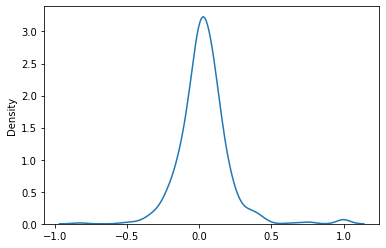

In [103]:
sns.kdeplot(weighted)

<AxesSubplot:ylabel='Density'>

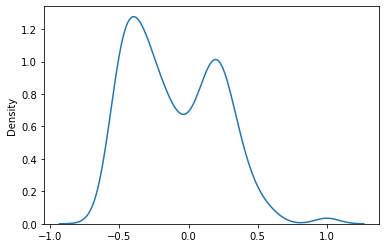

In [104]:
sns.kdeplot(community)

<AxesSubplot:ylabel='Density'>

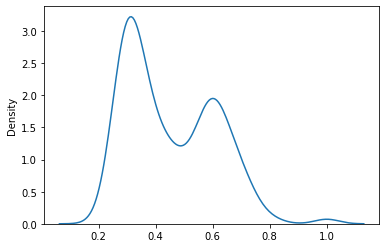

In [26]:
sns.kdeplot(community)

In [85]:
for i in range(len(w_to_kde)):
    w_to_kde[i] = round(w_to_kde[i], 1)

In [86]:
Counter(w_to_kde)

Counter({0.6: 142,
         0.5: 372,
         0.7: 21,
         0.4: 95,
         0.3: 11,
         0.2: 2,
         1.0: 5,
         0.8: 1,
         0.9: 2})

<AxesSubplot:ylabel='Density'>

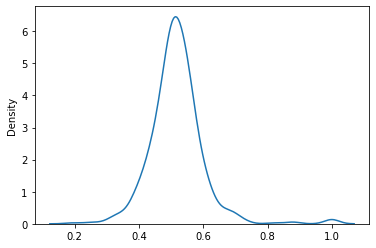

In [52]:
sns.kdeplot(context_to_kde)

In [41]:
com_to_nodes

defaultdict(list,
            {15: [0,
              8,
              12,
              14,
              17,
              25,
              28,
              44,
              55,
              64,
              72,
              73,
              82,
              85,
              86,
              87,
              91,
              57,
              105,
              106,
              107,
              108,
              126,
              129,
              137,
              145,
              149,
              155,
              163,
              164,
              167,
              179,
              181,
              204,
              208,
              210,
              212,
              216,
              228,
              231,
              234,
              243,
              244,
              259,
              235,
              264,
              278,
              119,
              284,
              285,
              293,
              309,
          

In [ ]:
df = pd.DataFrame(data=dict_to_df)
df
df.to_json("cambridge.json")

In [ ]:
#for node in list(g.nodes())[:20]:
 #   attr = attrs[node]
  #  egonet = nx.ego_graph(g, node)
   # egonet_attrs = list(nx.get_node_attributes(egonet, 'homogeneity').values())
    #avg = np.mean(egonet_attrs)
    
    #print(attr, hs[node], avg)